# Diabetic Retinopathy ResNetCAM

**Downloading data**

In [1]:
!rm -rf sample_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [4]:
!pwd

/content/drive/My Drive/Kaggle


**Importing the required libraries**

In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
import os
import gc
import numpy as np
import pandas as pd
import glob
import psutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
from sklearn.model_selection import train_test_split
from tensorflow import set_random_seed
import tensorflow as tf
import keras
import cv2
from PIL import Image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model,Sequential
from keras.layers import BatchNormalization
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Input
from keras import backend as K

**Declaring the constansts**

In [8]:
SEED = 4199
np.random.seed(SEED)
set_random_seed(SEED)
dir_path = "/content/drive/My Drive/Kaggle/"
IMG_DIM = 224
BATCH_SIZE = 32
CHANNEL_SIZE = 3
NUM_EPOCHS = 30
TRAIN_DIR = 'train'
TEST_DIR = 'train'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
CLASSA = {0: "No DR", 1: "DR"}
NUM_CLASSS = 5
NUM_CLASSA = 2

In [9]:
ROOT_PATH = '/content/drive/My Drive/Kaggle'
TRAIN_PATH = '/content/drive/My Drive/Kaggle/' + TRAIN_DIR 
TEST_PATH = '/content/drive/My Drive/Kaggle/' + TEST_DIR 
dir_path = ROOT_PATH + '/'

**Loading the dataframes**

In [10]:
# print names of train images
test_img_names = glob.glob(TRAIN_PATH + '/*.jpeg')
#print(train_img_names)

In [19]:
df_test = pd.read_csv(ROOT_PATH + '/trainLabels.csv',header=0,names=['id_code','diagnosis'])
#print(df_train)

In [20]:
df_test.head()

,id_code,diagnosis
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [21]:
# Function to show one image

def draw_img(imgs, target_dir, class_label='0'):
    for row in enumerate(imgs.iterrows()):
        name = row[1][1]['id_code'] + '.jpeg'
        print(name)
        plt.figure(figsize=(3,2))
        img = plt.imread(dir_path + target_dir + '/' + name)
        plt.imshow(img)
        plt.title(class_label)
        plt.show()
        del img
        gc.collect()

**Showing randomly chosen Severe DR image one at a time** 

25620_right.jpeg


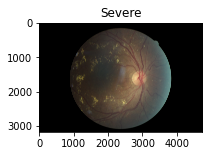

In [22]:
# Showing the class 3 image randomly
CLASS_ID = 3
draw_img(df_test[df_test.diagnosis == CLASS_ID].sample(n=1), TEST_DIR, CLASSS[CLASS_ID])

In [23]:
gc.collect()

0

**Get test(validation) set**

In [24]:
# !pip install -U imbalanced-learn

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [26]:
undersample = RandomUnderSampler(sampling_strategy={0: 840, 1: 210, 2: 210, 3: 210, 4: 210})
# fit and apply the transform
X_over, y_over = undersample.fit_resample(df_test, df_test.diagnosis)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [27]:
dft = pd.DataFrame(X_over,columns=['id_code','diagnosis'])

In [28]:
dft.head()

,id_code,diagnosis
0,19930_right,0
1,30376_right,0
2,14009_right,0
3,31488_left,0
4,18570_right,0


In [29]:
# Split Dataset
y = dft[['diagnosis']]
X_test = dft

In [30]:
df_stest = pd.DataFrame(X_test,columns=['id_code','diagnosis'])
# df_stest = df_stest.replace([1,2,3,4],1)

In [31]:
df_stest.groupby('diagnosis').count()

,id_code
diagnosis,
0,840
1,210
2,210
3,210
4,210


**Obervations:**
The differences between the classes are very minute and intricate in *some cases*, which is difficult to detect by human eyes. So to capture the intricacies we can consider using ResNet Network as it combines the information from different scales of the image and the 1x1 convolution helps to detect the complex functions as well as it helps to reduce dimension.


**Defining the ResNet network**

In [32]:
# input_tensor = Input(shape = (224, 224, 3))

# # create the base pre-trained model
# base_model = ResNet50(weights="imagenet", include_top=True, input_tensor=input_tensor)
# #base_model.load_weights('/content/drive/My Drive/Kaggle/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# # add a global spatial average pooling layer

# x = base_model.get_layer('avg_pool').output
# x = Flatten(name='flatten')(x)
# predictions = Dense(num_classes, activation='softmax', name='output_layer')(x)
# model = Model(inputs=image_input,outputs=predictions)

# # first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers

# for layer in model.layers[:-1]:
# 	layer.trainable = False
    
# print(model.summary())

In [33]:
# [layer.trainable for layer in model.layers]

In [34]:
# tf_model = tf.keras.models.Model(model)

In [35]:
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tf.logging.set_verbosity(tf.logging.INFO)

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     tf_model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)))

In [36]:
# model = tpu_model

In [37]:
# epochs = 30
# lrate = 0.01
# # momentum = tf.train.MomentumOptimizer(learning_rate=lrate, momentum=0.9, use_nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())

df_stest.id_code = df_stest.id_code.apply(lambda x: x + ".jpeg")
df_stest['diagnosis'] = df_stest['diagnosis'].astype('str')

available RAM: svmem(total=13653602304, available=12473274368, percent=8.6, used=1249595392, free=9541038080, active=1004949504, inactive=2781302784, buffers=93429760, cached=2769539072, shared=987136, slab=195117056)
available RAM: svmem(total=13653602304, available=12473380864, percent=8.6, used=1249484800, free=9541128192, active=1005092864, inactive=2781319168, buffers=93429760, cached=2769559552, shared=987136, slab=195084288)


In [95]:
df_stest.head()

,id_code,diagnosis
0,19930_right.jpeg,0
1,30376_right.jpeg,0
2,14009_right.jpeg,0
3,31488_left.jpeg,0
4,18570_right.jpeg,0


**GradCAM Models**

In [40]:
def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

In [41]:
def generate_gradcam(img_tensor, model, class_index, activation_layer):
    model_input = model.input

    y_c = model.outputs[0].op.inputs[0][0, class_index]

    A_k = model.get_layer(activation_layer).output

    get_output = K.function([model_input], [A_k, K.gradients(y_c, A_k)[0]])
    [conv_output, grad_val] = get_output([img_tensor])

    conv_output = conv_output[0]
    grad_val = grad_val[0]

    weights = np.mean(grad_val, axis=(0, 1))

    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]

    grad_cam = np.maximum(grad_cam, 0)

    return grad_cam, weights

In [42]:
def generate_cam(img_tensor, model, class_index, activation_layer):
    model_input = model.input

    A_k = model.get_layer(activation_layer).output

    get_output = K.function([model_input], [A_k])
    [conv_output] = get_output([img_tensor])

    conv_output = conv_output[0]

    weights = model.layers[-1].get_weights()[0][:, class_index]

    cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        cam += w * conv_output[:, :, k]

    return cam, weights

**Load Model**

In [43]:
!nvidia-smi

Sun Dec 20 00:11:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
model = keras.models.load_model('/content/drive/My Drive/Kaggle/models/resnet50_gradcam_final.h5')
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


**Testing one DR Gradcam**

In [83]:
img_width, img_height = 224,224

In [118]:
# Showing the class 3 image randomly
CLASS_ID = 3
imgs = df_test[df_test.diagnosis == CLASS_ID].sample(n=1)

In [119]:
for row in enumerate(imgs.iterrows()):
        name = row[1][1]['id_code'] + '.jpeg'
        print(name)
        plt.figure(figsize=(3,2))
        img_path = dir_path + 'train' + '/' + name

23095_right.jpeg


<Figure size 216x144 with 0 Axes>

In [120]:
img = load_image(path=img_path, target_size=(img_width, img_height))

In [121]:
preds = model.predict(img)
predicted_class = preds.argmax(axis=1)[0]
    
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
    
print("predicted top1 class:", predicted_class)
# print('Predicted:', decode_predictions(preds, top=1)[0])
    
conv_name = 'activation_49'
# conv_name = 'mixed10'
grad_cam, grad_val = generate_gradcam(img, model, predicted_class, conv_name)
cam, cam_weight = generate_cam(img, model, predicted_class, conv_name)

predicted top1 class: 4


In [122]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img_width, img_height))

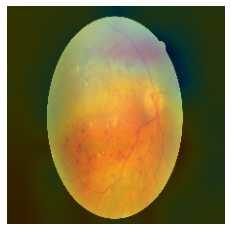

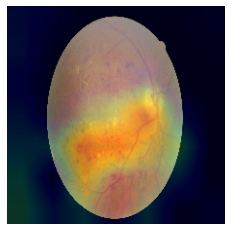

In [123]:
cam = cv2.resize(cam, (img_width, img_height))
plt.figure(0)
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=.2)
plt.axis('off')
grad_cam = cv2.resize(grad_cam, (img_width, img_height))
plt.figure(1)
plt.imshow(img)
plt.imshow(grad_cam, cmap="jet", alpha=.2)
plt.axis('off')
plt.show()

In [124]:
test_datagen = image.ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_stest,
                                                  directory= TEST_PATH  + '/',
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=True,
                                                  class_mode=None,
                                                  seed=SEED)
# del df_test
print(df_stest.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

Found 1680 validated image filenames.
1680


2730

In [126]:
# evaluating the model on test data

tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model.predict_generator(generator=test_generator, steps=ceil(df_stest.shape[0]))
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))





  0%|          | 0/5 [00:00<?, ?it/s]


In [108]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1680

In [109]:
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": predicted_class_indices})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("result.csv", index=False)

In [111]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(results.diagnosis,df_stest.diagnosis.astype('int')))
print(accuracy_score(results.diagnosis,df_stest.diagnosis.astype('int')))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67      1680
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.50      1680
   macro avg       0.20      0.10      0.13      1680
weighted avg       1.00      0.50      0.67      1680

0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
    open('test.jpeg', 'wb').write(v)
    break
uploaded_list = list(uploaded.keys())

Saving 17_left.jpeg to 17_left.jpeg


In [ ]:
img = load_image(path='test.jpeg', target_size=(img_width, img_height))

In [ ]:
preds = model.predict(img)
predicted_class = preds.argmax(axis=1)[0]
    
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
    
print("predicted top1 class:", predicted_class)
# print('Predicted:', decode_predictions(preds, top=1)[0])
    
conv_name = 'activation_49'
# conv_name = 'mixed10'
grad_cam, grad_val = generate_gradcam(img, model, predicted_class, conv_name)
cam, cam_weight = generate_cam(img, model, predicted_class, conv_name)

predicted top1 class: 0


In [ ]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img_width, img_height))

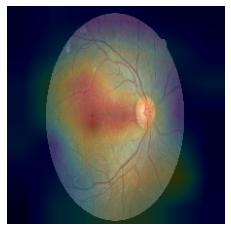

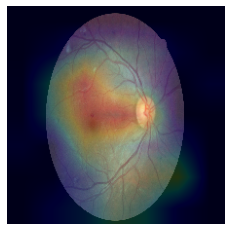

In [ ]:
cam = cv2.resize(cam, (img_width, img_height))
plt.figure(0)
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=.2)
plt.axis('off')
grad_cam = cv2.resize(grad_cam, (img_width, img_height))
plt.figure(1)
plt.imshow(img)
plt.imshow(grad_cam, cmap="jet", alpha=.2)
plt.axis('off')
plt.show()